In [1]:
import scanpy as sc

In [2]:
adata = sc.read_csv(r"C:\Users\liamm\Desktop\GSE171524_RAW (1)\GSM5226574_C51ctr_raw_counts.csv").T
adata

AnnData object with n_obs × n_vars = 6099 × 34546

In [3]:
adata.X.shape

(6099, 34546)

In [4]:
import scvi

In [5]:
adata

AnnData object with n_obs × n_vars = 6099 × 34546

In [6]:
sc.pp.filter_genes(adata, min_cells = 10)

In [7]:
sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, flavor = 'seurat_v3')

In [8]:
scvi.model.SCVI.setup_anndata(adata)
vae = scvi.model.SCVI(adata)
vae.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


In [9]:
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train()

INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.280. Signaling Trainer to stop.


In [10]:
df = solo.predict()
df['prediction'] = solo.predict(soft = False)

df.index = df.index.map(lambda x: x[:-2])

df

C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)


,doublet,singlet,prediction
TAGGTACCATGGCCAC-1,0.774327,0.225673,doublet
ATTCACTGTAACAGGC-1,0.967263,0.032737,doublet
TAACTTCCAACCACGC-1,0.570154,0.429846,doublet
TTGGGTACACGACAAG-1,0.861087,0.138913,doublet
AGGCCACAGAGTCACG-1,0.908594,0.091406,doublet
...,...,...,...
CGCCATTGTTTGCCGG-1,0.051175,0.948825,singlet
CACTGGGGTCTACGTA-1,0.000281,0.999719,singlet
CATACTTGTAGAGGAA-1,0.000801,0.999199,singlet
TTTGGTTTCCACGGAC-1,0.002600,0.997400,singlet


In [11]:
df.groupby('prediction').count()

,doublet,singlet
prediction,,
doublet,1067,1067
singlet,5032,5032


In [12]:
df['dif'] = df.doublet - df.singlet
df

,doublet,singlet,prediction,dif
TAGGTACCATGGCCAC-1,0.774327,0.225673,doublet,0.548653
ATTCACTGTAACAGGC-1,0.967263,0.032737,doublet,0.934527
TAACTTCCAACCACGC-1,0.570154,0.429846,doublet,0.140309
TTGGGTACACGACAAG-1,0.861087,0.138913,doublet,0.722174
AGGCCACAGAGTCACG-1,0.908594,0.091406,doublet,0.817187
...,...,...,...,...
CGCCATTGTTTGCCGG-1,0.051175,0.948825,singlet,-0.897651
CACTGGGGTCTACGTA-1,0.000281,0.999719,singlet,-0.999437
CATACTTGTAGAGGAA-1,0.000801,0.999199,singlet,-0.998398
TTTGGTTTCCACGGAC-1,0.002600,0.997400,singlet,-0.994799


In [13]:
import seaborn as sns

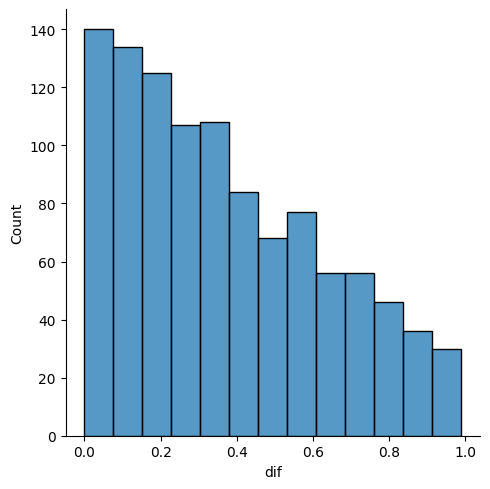

In [14]:
sns.displot(df[df.prediction == 'doublet'], x = 'dif')

In [15]:
doublets = df[(df.prediction == 'doublet') & (df.dif > 0.8)]
doublets

,doublet,singlet,prediction,dif
ATTCACTGTAACAGGC-1,0.967263,0.032737,doublet,0.934527
AGGCCACAGAGTCACG-1,0.908594,0.091406,doublet,0.817187
CACTGAAGTCGAAGCA-1,0.922437,0.077563,doublet,0.844874
ACTGATGTCTGCACCT-1,0.916294,0.083706,doublet,0.832587
ACTTCCGCACAACGCC-1,0.982677,0.017323,doublet,0.965353
...,...,...,...,...
GGGTAGAAGGTCGACA-1,0.940743,0.059257,doublet,0.881486
GGGTAGATCAACGCTA-1,0.928405,0.071595,doublet,0.856810
GTCCTCACAGGTTCCG-1,0.944014,0.055986,doublet,0.888028
CTCAACCCACCGGTCA-1,0.920623,0.079377,doublet,0.841246


In [16]:
adata = sc.read_csv(r"C:\Users\liamm\Desktop\GSE171524_RAW (1)\GSM5226574_C51ctr_raw_counts.csv").T

In [17]:
adata.obs['doublet'] = adata.obs.index.isin(doublets.index)

In [18]:
adata.obs

,doublet
TAGGTACCATGGCCAC-1_1,False
ATTCACTGTAACAGGC-1_1,False
TAACTTCCAACCACGC-1_1,False
TTGGGTACACGACAAG-1_1,False
AGGCCACAGAGTCACG-1_1,False
...,...
CGCCATTGTTTGCCGG-1_1,False
CACTGGGGTCTACGTA-1_1,False
CATACTTGTAGAGGAA-1_1,False
TTTGGTTTCCACGGAC-1_1,False


In [19]:
adata = adata[~adata.obs.doublet]

In [20]:
adata

View of AnnData object with n_obs × n_vars = 6099 × 34546
    obs: 'doublet'

In [21]:
adata.var['mt'] = adata.var.index.str.startswith('MT-')

C:\Users\liamm\AppData\Local\Temp\ipykernel_15520\310233584.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['mt'] = adata.var.index.str.startswith('MT-')


In [22]:
adata.var

,mt
AL627309.1,False
AL627309.5,False
AL627309.4,False
AL669831.2,False
LINC01409,False
...,...
VN1R2,False
AL031676.1,False
SMIM34A,False
AL050402.1,False


In [23]:
import pandas as pd

In [24]:
ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"

In [25]:
ribo_genes = pd.read_table(ribo_url, skiprows=2, header = None)
ribo_genes

,0
0,FAU
1,MRPL13
2,RPL10
3,RPL10A
4,RPL10L
...,...
83,RPS9
84,RPSA
85,RSL24D1
86,RSL24D1P11


In [26]:
adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)

In [27]:
adata.obs

,doublet
TAGGTACCATGGCCAC-1_1,False
ATTCACTGTAACAGGC-1_1,False
TAACTTCCAACCACGC-1_1,False
TTGGGTACACGACAAG-1_1,False
AGGCCACAGAGTCACG-1_1,False
...,...
CGCCATTGTTTGCCGG-1_1,False
CACTGGGGTCTACGTA-1_1,False
CATACTTGTAGAGGAA-1_1,False
TTTGGTTTCCACGGAC-1_1,False


In [28]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)

In [29]:
adata.var.sort_values('n_cells_by_counts')

,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
AL445072.1,False,False,0,0.000000,100.000000,0.0
AL050402.1,False,False,0,0.000000,100.000000,0.0
SMIM34A,False,False,0,0.000000,100.000000,0.0
AL031676.1,False,False,0,0.000000,100.000000,0.0
VN1R2,False,False,0,0.000000,100.000000,0.0
...,...,...,...,...,...,...
AKAP13,False,False,4458,3.054271,26.906050,18628.0
NEAT1,False,False,4546,5.314150,25.463191,32411.0
MBNL1,False,False,4554,2.877029,25.332022,17547.0
ZBTB20,False,False,4699,2.601082,22.954583,15864.0


In [30]:
sc.pp.filter_genes(adata, min_cells=3)

In [31]:
adata.var.sort_values('n_cells_by_counts')

,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells
SYT14,False,False,3,0.000492,99.950812,3.0,3
LPGAT1-AS1,False,False,3,0.000492,99.950812,3.0,3
AC092803.2,False,False,3,0.000492,99.950812,3.0,3
KCNK2,False,False,3,0.000492,99.950812,3.0,3
AL023754.1,False,False,3,0.000492,99.950812,3.0,3
...,...,...,...,...,...,...,...
AKAP13,False,False,4458,3.054271,26.906050,18628.0,4458
NEAT1,False,False,4546,5.314150,25.463191,32411.0,4546
MBNL1,False,False,4554,2.877029,25.332022,17547.0,4554
ZBTB20,False,False,4699,2.601082,22.954583,15864.0,4699


In [32]:
adata.obs.sort_values('n_genes_by_counts')

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
TAGGGTTTCTGGCTGG-1_1,False,276,419.0,1.0,0.238663,1.0,0.238663
CGTGCTTCAAAGGGCT-1_1,False,277,432.0,41.0,9.490741,0.0,0.000000
TGACAGTTCTAAACGC-1_1,False,278,414.0,0.0,0.000000,0.0,0.000000
CTCTGGTCACGACGAA-1_1,False,285,407.0,0.0,0.000000,0.0,0.000000
GTAAGTCGTATCGCGC-1_1,False,289,430.0,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...
TAACTTCCAACCACGC-1_1,False,5158,15645.0,221.0,1.412592,211.0,1.348674
CACTGAAGTCGAAGCA-1_1,False,5487,12725.0,355.0,2.789784,82.0,0.644401
AGGCCACAGAGTCACG-1_1,False,5544,13217.0,417.0,3.155028,82.0,0.620413
ATTCACTGTAACAGGC-1_1,False,6686,19020.0,404.0,2.124080,115.0,0.604627


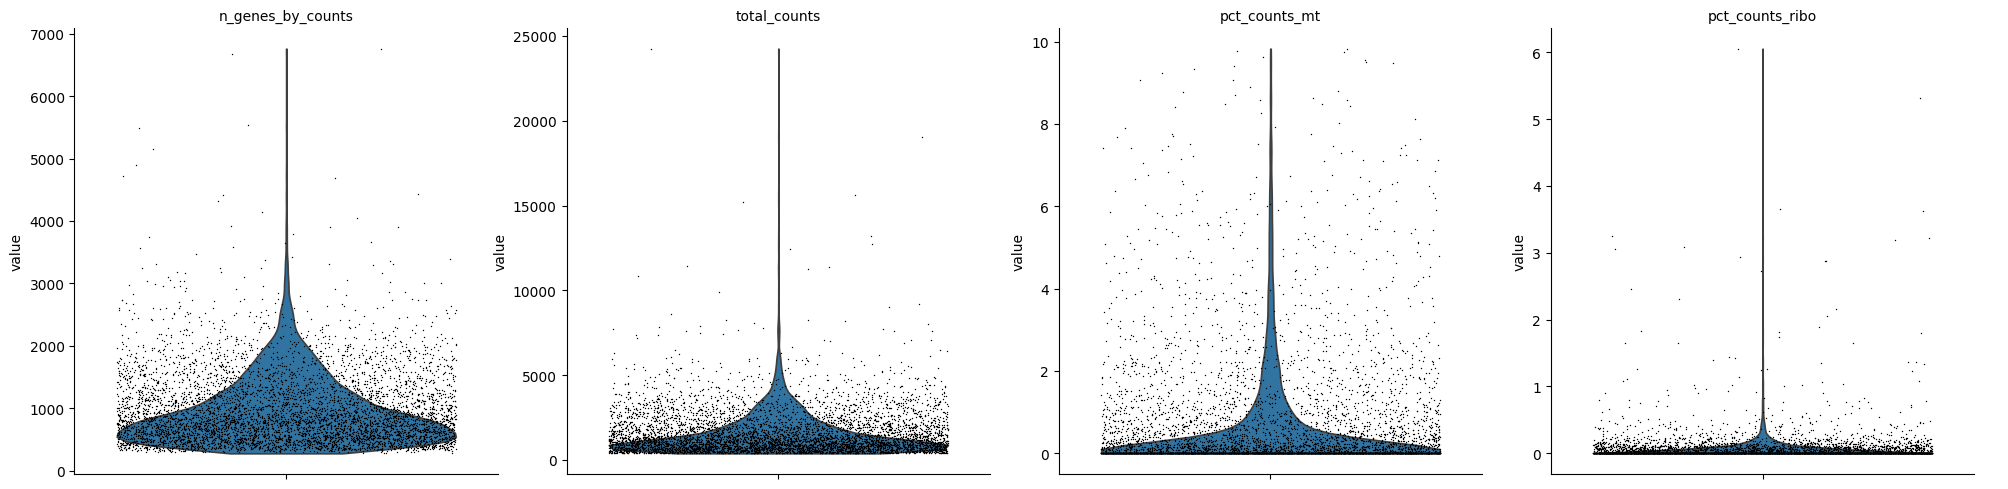

In [33]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'], 
             jitter=0.4, multi_panel=True)

In [34]:
import numpy as np

In [35]:
upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
upper_lim

np.float64(2479.08)

In [36]:
adata = adata[adata.obs.n_genes_by_counts < upper_lim]

In [37]:
adata.obs

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
CGTTCTGGTACTAGCT-1_1,False,2434,6047.0,6.0,0.099223,1.0,0.016537
CTGGCAGGTTCGGTAT-1_1,False,2444,5899.0,307.0,5.204272,5.0,0.084760
ACACCAACACAACGCC-1_1,False,2451,5497.0,0.0,0.000000,3.0,0.054575
CCTCAACCATACAGGG-1_1,False,2276,5434.0,38.0,0.699301,0.0,0.000000
ACAAAGATCCACAGGC-1_1,False,2310,5504.0,1.0,0.018169,1.0,0.018169
...,...,...,...,...,...,...,...
CGCCATTGTTTGCCGG-1_1,False,355,410.0,3.0,0.731707,0.0,0.000000
CACTGGGGTCTACGTA-1_1,False,346,403.0,0.0,0.000000,0.0,0.000000
CATACTTGTAGAGGAA-1_1,False,360,410.0,2.0,0.487805,0.0,0.000000
TTTGGTTTCCACGGAC-1_1,False,299,405.0,0.0,0.000000,2.0,0.493827


In [38]:
adata = adata[adata.obs.pct_counts_mt < 20]

In [39]:
adata = adata[adata.obs.pct_counts_ribo < 2]

In [40]:
adata

View of AnnData object with n_obs × n_vars = 5960 × 24660
    obs: 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

In [41]:
#Normaliziation

In [42]:
adata.X.sum(axis = 1)

array([6043., 5895., 5496., ...,  410.,  405.,  410.], dtype=float32)

In [43]:
sc.pp.normalize_total(adata, target_sum=1e4) #normalize every cell to 10,000 UMI

C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [44]:
adata.X.sum(axis = 1)

array([10000., 10000., 10000., ..., 10000., 10000., 10000.], dtype=float32)

In [45]:
sc.pp.log1p(adata) #change to log 

In [46]:
adata.X.sum(axis = 1)

array([3155.047  , 3218.0122 , 3416.0486 , ..., 1191.2708 , 1022.75116,
       1162.8785 ], dtype=float32)

In [47]:
adata.raw = adata

In [48]:
#Clustering

In [49]:
sc.pp.highly_variable_genes(adata, n_top_genes = 2000)

In [50]:
adata.var

,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,highly_variable,means,dispersions,dispersions_norm
AL627309.1,False,False,8,0.001312,99.868831,8.0,8,False,0.011136,2.697174,1.153160
AL627309.5,False,False,33,0.005411,99.458928,33.0,33,False,0.028855,2.254608,-0.150810
AL627309.4,False,False,4,0.000656,99.934415,4.0,4,False,0.002331,1.702854,-1.776493
LINC01409,False,False,274,0.048697,95.507460,297.0,274,False,0.270478,2.286819,-0.055904
FAM87B,False,False,6,0.000984,99.901623,6.0,6,False,0.006682,1.947490,-1.055700
...,...,...,...,...,...,...,...,...,...,...,...
AL354822.1,False,False,133,0.022627,97.819315,138.0,133,False,0.153974,2.375807,0.206288
AL592183.1,False,False,1003,0.198721,83.554681,1212.0,1003,False,0.875225,2.469386,-0.406744
AC240274.1,False,False,162,0.027382,97.343827,167.0,162,False,0.150268,2.265893,-0.117561
AC007325.4,False,False,4,0.000656,99.934415,4.0,4,False,0.002801,1.579830,-2.138971


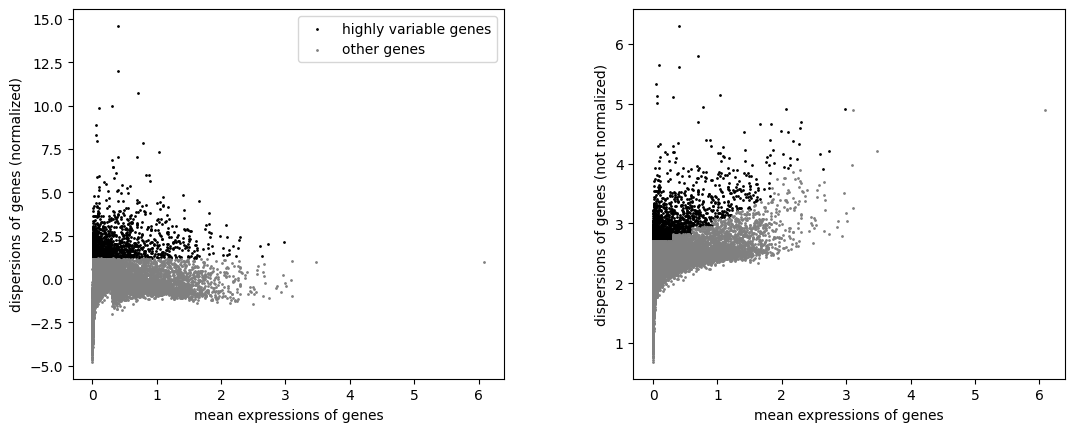

In [51]:
sc.pl.highly_variable_genes(adata)

In [52]:
adata = adata[:, adata.var.highly_variable]

In [53]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt', 'pct_counts_ribo'])

C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_simple.py:672: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [54]:
sc.pp.scale(adata, max_value=10)

In [55]:
sc.tl.pca(adata, svd_solver='arpack')

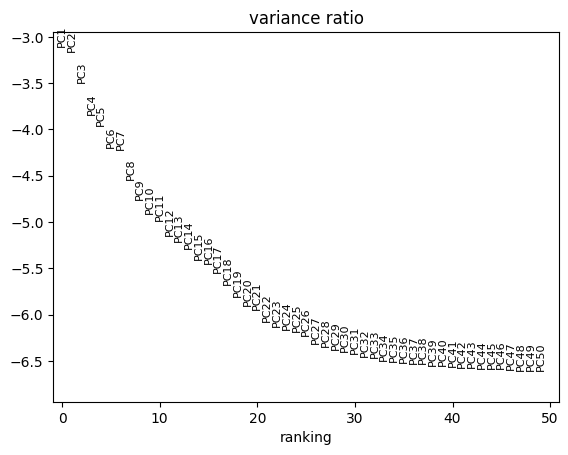

In [56]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50)

In [57]:
sc.pp.neighbors(adata, n_pcs = 30) #Flattens around 30

In [58]:
sc.tl.umap(adata)

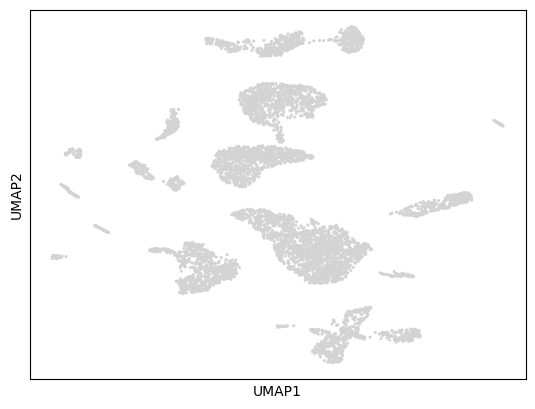

In [59]:
sc.pl.umap(adata)

In [60]:
!pip install leidenalg

In [62]:
import leidenalg

In [63]:
sc.tl.leiden(adata, resolution = 0.5)

C:\Users\liamm\AppData\Local\Temp\ipykernel_15520\3246266323.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution = 0.5)


In [64]:
adata.obs

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,leiden
CGTTCTGGTACTAGCT-1_1,False,2434,6047.0,6.0,0.099223,1.0,0.016537,2
CTGGCAGGTTCGGTAT-1_1,False,2444,5899.0,307.0,5.204272,5.0,0.084760,2
ACACCAACACAACGCC-1_1,False,2451,5497.0,0.0,0.000000,3.0,0.054575,1
CCTCAACCATACAGGG-1_1,False,2276,5434.0,38.0,0.699301,0.0,0.000000,11
ACAAAGATCCACAGGC-1_1,False,2310,5504.0,1.0,0.018169,1.0,0.018169,2
...,...,...,...,...,...,...,...,...
CGCCATTGTTTGCCGG-1_1,False,355,410.0,3.0,0.731707,0.0,0.000000,6
CACTGGGGTCTACGTA-1_1,False,346,403.0,0.0,0.000000,0.0,0.000000,1
CATACTTGTAGAGGAA-1_1,False,360,410.0,2.0,0.487805,0.0,0.000000,0
TTTGGTTTCCACGGAC-1_1,False,299,405.0,0.0,0.000000,2.0,0.493827,12


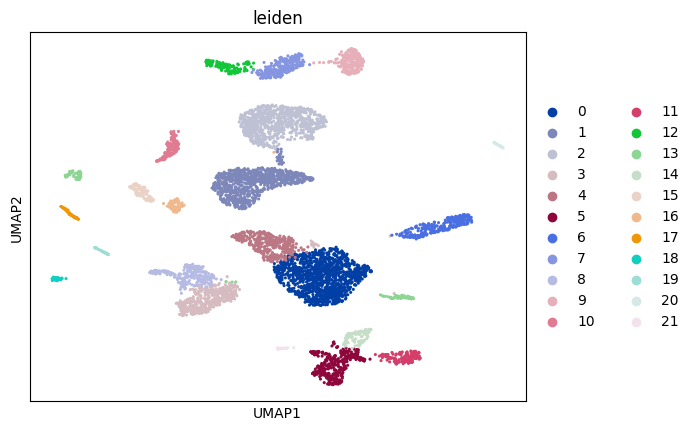

In [65]:
sc.pl.umap(adata, color=['leiden'])

In [66]:
def pp(csv_path):
    adata = sc.read_csv(csv_path).T
    sc.pp.filter_genes(adata, min_cells = 10)
    sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, flavor = 'seurat_v3')
    scvi.model.SCVI.setup_anndata(adata)
    vae = scvi.model.SCVI(adata)
    vae.train()
    solo = scvi.external.SOLO.from_scvi_model(vae)
    solo.train()
    df = solo.predict()
    df['prediction'] = solo.predict(soft = False)
    df.index = df.index.map(lambda x: x[:-2])
    df['dif'] = df.doublet - df.singlet
    doublets = df[(df.prediction == 'doublet') & (df.dif > 1)]
    
    adata = sc.read_csv(csv_path).T
    adata.obs['Sample'] = csv_path.split('_')[2] #'raw_counts/GSM5226574_C51ctr_raw_counts.csv'
    
    adata.obs['doublet'] = adata.obs.index.isin(doublets.index)
    adata = adata[~adata.obs.doublet]
    
    
    sc.pp.filter_cells(adata, min_genes=200) #get rid of cells with fewer than 200 genes
    #sc.pp.filter_genes(adata, min_cells=3) #get rid of genes that are found in fewer than 3 cells
    adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
    adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)
    upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
    adata = adata[adata.obs.n_genes_by_counts < upper_lim]
    adata = adata[adata.obs.pct_counts_mt < 20]
    adata = adata[adata.obs.pct_counts_ribo < 2]

    return adata

In [80]:
import os

folder = r"C:\Users\liamm\Desktop\GSE171524_RAW (1)\raw_counts"  # raw string to avoid escape errors
print(os.listdir(folder))  # ls

['GSM5226574_C51ctr_raw_counts.csv', 'GSM5226575_C52ctr_raw_counts.csv', 'GSM5226576_C53ctr_raw_counts.csv', 'GSM5226577_C54ctr_raw_counts.csv', 'GSM5226578_C55ctr_raw_counts.csv', 'GSM5226579_C56ctr_raw_counts.csv', 'GSM5226580_C57ctr_raw_counts.csv', 'GSM5226581_L01cov_raw_counts.csv', 'GSM5226582_L03cov_raw_counts.csv', 'GSM5226583_L04cov_raw_counts.csv', 'GSM5226584_L04covaddon_raw_counts.csv', 'GSM5226585_L05cov_raw_counts.csv', 'GSM5226586_L06cov_raw_counts.csv', 'GSM5226587_L07cov_raw_counts.csv', 'GSM5226588_L08cov_raw_counts.csv', 'GSM5226589_L09cov_raw_counts.csv', 'GSM5226590_L10cov_raw_counts.csv', 'GSM5226591_L11cov_raw_counts.csv', 'GSM5226592_L12cov_raw_counts.csv', 'GSM5226593_L13cov_raw_counts.csv', 'GSM5226594_L15cov_raw_counts.csv', 'GSM5226595_L16cov_raw_counts.csv', 'GSM5226596_L17cov_raw_counts.csv', 'GSM5226597_L18cov_raw_counts.csv', 'GSM5226598_L19cov_raw_counts.csv', 'GSM5226599_L21cov_raw_counts.csv', 'GSM5226600_L22cov_raw_counts.csv']


In [81]:
out = []
for file in os.listdir(folder):
    full_path = os.path.join(folder, file)
    print(full_path)  # Optional: for debugging
    out.append(pp(full_path))

C:\Users\liamm\Desktop\GSE171524_RAW (1)\raw_counts\GSM5226574_C51ctr_raw_counts.csv


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.279. Signaling Trainer to stop.


C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_simple.py:168: ImplicitModificationWarning: Trying to modify attribute `.obs` of vi

C:\Users\liamm\Desktop\GSE171524_RAW (1)\raw_counts\GSM5226575_C52ctr_raw_counts.csv


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.287. Signaling Trainer to stop.


C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_simple.py:168: ImplicitModificationWarning: Trying to modify attribute `.obs` of vi

C:\Users\liamm\Desktop\GSE171524_RAW (1)\raw_counts\GSM5226576_C53ctr_raw_counts.csv


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.301. Signaling Trainer to stop.


C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_simple.py:168: ImplicitModificationWarning: Trying to modify attribute `.obs` of vi

C:\Users\liamm\Desktop\GSE171524_RAW (1)\raw_counts\GSM5226577_C54ctr_raw_counts.csv


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.242. Signaling Trainer to stop.


C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_simple.py:168: ImplicitModificationWarning: Trying to modify attribute `.obs` of vi

C:\Users\liamm\Desktop\GSE171524_RAW (1)\raw_counts\GSM5226578_C55ctr_raw_counts.csv


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.226. Signaling Trainer to stop.


C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_simple.py:168: ImplicitModificationWarning: Trying to modify attribute `.obs` of vi

C:\Users\liamm\Desktop\GSE171524_RAW (1)\raw_counts\GSM5226579_C56ctr_raw_counts.csv


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.242. Signaling Trainer to stop.


C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_simple.py:168: ImplicitModificationWarning: Trying to modify attribute `.obs` of vi

C:\Users\liamm\Desktop\GSE171524_RAW (1)\raw_counts\GSM5226580_C57ctr_raw_counts.csv


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.226. Signaling Trainer to stop.


C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_simple.py:168: ImplicitModificationWarning: Trying to modify attribute `.obs` of vi

C:\Users\liamm\Desktop\GSE171524_RAW (1)\raw_counts\GSM5226581_L01cov_raw_counts.csv


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.266. Signaling Trainer to stop.


C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_simple.py:168: ImplicitModificationWarning: Trying to modify attribute `.obs` of vi

C:\Users\liamm\Desktop\GSE171524_RAW (1)\raw_counts\GSM5226582_L03cov_raw_counts.csv


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.314. Signaling Trainer to stop.


C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_simple.py:168: ImplicitModificationWarning: Trying to modify attribute `.obs` of vi

C:\Users\liamm\Desktop\GSE171524_RAW (1)\raw_counts\GSM5226583_L04cov_raw_counts.csv


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.276. Signaling Trainer to stop.


C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_simple.py:168: ImplicitModificationWarning: Trying to modify attribute `.obs` of vi

C:\Users\liamm\Desktop\GSE171524_RAW (1)\raw_counts\GSM5226584_L04covaddon_raw_counts.csv


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.263. Signaling Trainer to stop.


C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_simple.py:168: ImplicitModificationWarning: Trying to modify attribute `.obs` of vi

C:\Users\liamm\Desktop\GSE171524_RAW (1)\raw_counts\GSM5226585_L05cov_raw_counts.csv


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.329. Signaling Trainer to stop.


C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_simple.py:168: ImplicitModificationWarning: Trying to modify attribute `.obs` of vi

C:\Users\liamm\Desktop\GSE171524_RAW (1)\raw_counts\GSM5226586_L06cov_raw_counts.csv


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.286. Signaling Trainer to stop.


C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_simple.py:168: ImplicitModificationWarning: Trying to modify attribute `.obs` of vi

C:\Users\liamm\Desktop\GSE171524_RAW (1)\raw_counts\GSM5226587_L07cov_raw_counts.csv


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.329. Signaling Trainer to stop.


C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_simple.py:168: ImplicitModificationWarning: Trying to modify attribute `.obs` of vi

C:\Users\liamm\Desktop\GSE171524_RAW (1)\raw_counts\GSM5226588_L08cov_raw_counts.csv


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.257. Signaling Trainer to stop.


C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_simple.py:168: ImplicitModificationWarning: Trying to modify attribute `.obs` of vi

C:\Users\liamm\Desktop\GSE171524_RAW (1)\raw_counts\GSM5226589_L09cov_raw_counts.csv


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.244. Signaling Trainer to stop.


C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_simple.py:168: ImplicitModificationWarning: Trying to modify attribute `.obs` of vi

C:\Users\liamm\Desktop\GSE171524_RAW (1)\raw_counts\GSM5226590_L10cov_raw_counts.csv


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_simple.py:168: ImplicitModificatio

C:\Users\liamm\Desktop\GSE171524_RAW (1)\raw_counts\GSM5226591_L11cov_raw_counts.csv


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.367. Signaling Trainer to stop.


C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_simple.py:168: ImplicitModificationWarning: Trying to modify attribute `.obs` of vi

C:\Users\liamm\Desktop\GSE171524_RAW (1)\raw_counts\GSM5226592_L12cov_raw_counts.csv


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.322. Signaling Trainer to stop.


C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_simple.py:168: ImplicitModificationWarning: Trying to modify attribute `.obs` of vi

C:\Users\liamm\Desktop\GSE171524_RAW (1)\raw_counts\GSM5226593_L13cov_raw_counts.csv


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.290. Signaling Trainer to stop.


C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_simple.py:168: ImplicitModificationWarning: Trying to modify attribute `.obs` of vi

C:\Users\liamm\Desktop\GSE171524_RAW (1)\raw_counts\GSM5226594_L15cov_raw_counts.csv


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.286. Signaling Trainer to stop.


C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_simple.py:168: ImplicitModificationWarning: Trying to modify attribute `.obs` of vi

C:\Users\liamm\Desktop\GSE171524_RAW (1)\raw_counts\GSM5226595_L16cov_raw_counts.csv


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.317. Signaling Trainer to stop.


C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_simple.py:168: ImplicitModificationWarning: Trying to modify attribute `.obs` of vi

C:\Users\liamm\Desktop\GSE171524_RAW (1)\raw_counts\GSM5226596_L17cov_raw_counts.csv


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.261. Signaling Trainer to stop.


C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_simple.py:168: ImplicitModificationWarning: Trying to modify attribute `.obs` of vi

C:\Users\liamm\Desktop\GSE171524_RAW (1)\raw_counts\GSM5226597_L18cov_raw_counts.csv


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.217. Signaling Trainer to stop.


C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_simple.py:168: ImplicitModificationWarning: Trying to modify attribute `.obs` of vi

C:\Users\liamm\Desktop\GSE171524_RAW (1)\raw_counts\GSM5226598_L19cov_raw_counts.csv


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.341. Signaling Trainer to stop.


C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_simple.py:168: ImplicitModificationWarning: Trying to modify attribute `.obs` of vi

C:\Users\liamm\Desktop\GSE171524_RAW (1)\raw_counts\GSM5226599_L21cov_raw_counts.csv


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.326. Signaling Trainer to stop.


C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_simple.py:168: ImplicitModificationWarning: Trying to modify attribute `.obs` of vi

C:\Users\liamm\Desktop\GSE171524_RAW (1)\raw_counts\GSM5226600_L22cov_raw_counts.csv


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.297. Signaling Trainer to stop.


C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_simple.py:168: ImplicitModificationWarning: Trying to modify attribute `.obs` of vi

In [87]:
sc.concat(out) #108822 cells × 34546 genes

AnnData object with n_obs × n_vars = 108822 × 34546
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'

In [89]:
adata = sc.concat(out)

In [91]:
sc.pp.filter_genes(adata, min_cells = 10)

In [92]:
adata.X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [93]:
%pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [94]:
from scipy.sparse import csr_matrix

In [95]:
adata.X = csr_matrix(adata.X)

In [96]:
adata.X

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 95760461 stored elements and shape (108822, 29581)>

In [97]:
adata.write_h5ad('combined.h5ad')

In [98]:
adata

AnnData object with n_obs × n_vars = 108822 × 29581
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'n_cells'

In [99]:
adata.obs.groupby('Sample').count()

C:\Users\liamm\AppData\Local\Temp\ipykernel_15520\2340059915.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby('Sample').count()


,doublet,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
Sample,,,,,,,,
counts\GSM5226574,5960,5960,5960,5960,5960,5960,5960,5960
counts\GSM5226575,4415,4415,4415,4415,4415,4415,4415,4415
counts\GSM5226576,6928,6928,6928,6928,6928,6928,6928,6928
counts\GSM5226577,4284,4284,4284,4284,4284,4284,4284,4284
counts\GSM5226578,5565,5565,5565,5565,5565,5565,5565,5565
counts\GSM5226579,3904,3904,3904,3904,3904,3904,3904,3904
counts\GSM5226580,4687,4687,4687,4687,4687,4687,4687,4687
counts\GSM5226581,2952,2952,2952,2952,2952,2952,2952,2952
counts\GSM5226582,3953,3953,3953,3953,3953,3953,3953,3953


In [100]:
#Remove genes that are not in at least 100 cells

In [101]:
sc.pp.filter_genes(adata, min_cells = 100)

In [102]:
adata

AnnData object with n_obs × n_vars = 108822 × 21306
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'n_cells'

In [104]:
#Integration with scvi

In [105]:
adata.layers['counts'] = adata.X.copy()

In [106]:
#Normalize and log transform
sc.pp.normalize_total(adata, target_sum = 1e4)
sc.pp.log1p(adata)
adata.raw = adata

In [107]:
adata.obs.head()

,Sample,doublet,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
CGTTCTGGTACTAGCT-1_1,counts\GSM5226574,False,2434,2434,6047.0,0.0,0.0,1.0,0.016537
CTGGCAGGTTCGGTAT-1_1,counts\GSM5226574,False,2444,2444,5899.0,0.0,0.0,5.0,0.084760
ACACCAACACAACGCC-1_1,counts\GSM5226574,False,2451,2451,5497.0,0.0,0.0,3.0,0.054575
CCTCAACCATACAGGG-1_1,counts\GSM5226574,False,2276,2276,5434.0,0.0,0.0,0.0,0.000000
ACAAAGATCCACAGGC-1_1,counts\GSM5226574,False,2310,2310,5504.0,0.0,0.0,1.0,0.018169


In [108]:
adata

AnnData object with n_obs × n_vars = 108822 × 21306
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'n_cells'
    uns: 'log1p'
    layers: 'counts'

In [109]:
scvi.model.SCVI.setup_anndata(adata, layer = "counts",
                             categorical_covariate_keys=["Sample"],
                             continuous_covariate_keys=['pct_counts_mt', 'total_counts', 'pct_counts_ribo'])

In [110]:
model = scvi.model.SCVI(adata)

In [111]:
model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/74 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=74` reached.


In [115]:
adata.obsm['X_scVI'] = model.get_latent_representation()
# Number of cells = rows, with 10 columns. scVI array for clustering

In [117]:
adata.layers['scvi_normalized'] = model.get_normalized_expression(library_size = 1e4)

In [118]:
sc.pp.neighbors(adata, use_rep = 'X_scVI') #scanpy function to calculate neighbours

In [119]:
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution = 0.5) #cluster with leiden at default but resolution at 0.5

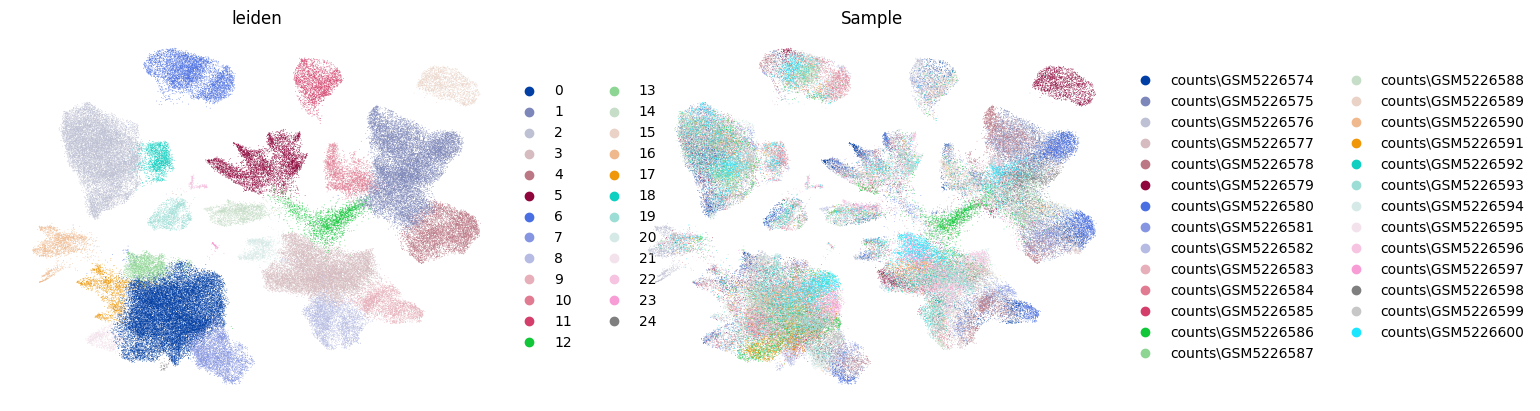

In [120]:
sc.pl.umap(adata, color = ['leiden', 'Sample'], frameon = False)

In [122]:
adata.write_h5ad('integrated.h5ad')

In [123]:
#Markers/Labels

In [124]:
sc.tl.leiden(adata, resolution = 1)

In [125]:
sc.tl.rank_genes_groups(adata, 'leiden') #just for the raw data 

C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\tools\_rank_genes_groups.py:429: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\tools\_rank_genes_groups.py:431: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
C:\Users\liamm\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\tools\_rank_g

In [126]:
markers = sc.get.rank_genes_groups_df(adata, None)
markers = markers[(markers.pvals_adj < 0.05) & (markers.logfoldchanges > .5)]
markers

,group,names,scores,logfoldchanges,pvals,pvals_adj
0,0,PRKG1,186.032852,4.295312,0.000000,0.000000
1,0,COL6A3,185.657974,6.572817,0.000000,0.000000
2,0,COL1A2,182.928909,6.923389,0.000000,0.000000
3,0,LAMA2,170.332352,5.608292,0.000000,0.000000
4,0,CACNA1C,165.551132,5.568882,0.000000,0.000000
...,...,...,...,...,...,...
618691,29,CAPNS1,2.118838,2.779352,0.037930,0.049391
618692,29,LAMTOR4,2.117363,2.920970,0.038059,0.049556
618693,29,IDH3B,2.115284,3.842780,0.038243,0.049789
618694,29,ATP6V0E2,2.114885,3.765459,0.038278,0.049832


In [127]:
markers_scvi = model.differential_expression(groupby = 'leiden')
markers_scvi

DE...:   0%|          | 0/30 [00:00<?, ?it/s]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
CDH11,0.9960,0.0040,5.517450,0.001626,0.000075,0.0,0.25,7.378604,7.409446,3.361786,...,3.045915,0.088436,0.722280,0.043009,18.067266,0.657276,True,0 vs Rest,0,Rest
GREM1,0.9952,0.0048,5.334326,0.000178,0.000004,0.0,0.25,10.240415,10.399576,4.173732,...,0.215660,0.003828,0.098161,0.001718,1.624630,0.020688,True,0 vs Rest,0,Rest
FAP,0.9948,0.0052,5.253881,0.000318,0.000015,0.0,0.25,6.472780,6.296318,3.109008,...,0.731117,0.014580,0.337889,0.009734,3.904248,0.102638,True,0 vs Rest,0,Rest
LUM,0.9942,0.0058,5.144079,0.000898,0.000033,0.0,0.25,7.301060,7.415454,3.142565,...,1.609641,0.040797,0.474214,0.020167,9.276564,0.287316,True,0 vs Rest,0,Rest
BX322234.1,0.9942,0.0058,5.144079,0.000367,0.000018,0.0,0.25,5.996234,6.204138,2.506929,...,0.575802,0.023645,0.273681,0.011997,3.480188,0.137145,True,0 vs Rest,0,Rest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DYNC1I2,0.5668,0.4332,0.268807,0.000079,0.000082,0.0,0.25,-0.016926,-0.031555,0.460192,...,0.075758,0.123450,0.060606,0.108141,0.915828,0.897552,False,29 vs Rest,29,Rest
SEPTIN2,0.5570,0.4430,0.228995,0.000187,0.000192,0.0,0.25,0.031701,0.056338,0.481087,...,0.227273,0.269803,0.181818,0.212972,2.356791,2.033632,False,29 vs Rest,29,Rest
RNF10,0.5506,0.4494,0.203095,0.000075,0.000089,0.0,0.25,-0.201024,-0.176825,0.405984,...,0.090909,0.116205,0.075758,0.105190,0.922614,0.919304,False,29 vs Rest,29,Rest
PCBP2,0.5400,0.4600,0.160343,0.000121,0.000134,0.0,0.25,-0.123108,-0.136264,0.389522,...,0.090909,0.177180,0.090909,0.151449,1.101086,1.310801,False,29 vs Rest,29,Rest


In [128]:
markers_scvi = markers_scvi[(markers_scvi['is_de_fdr_0.05']) & (markers_scvi.lfc_mean > .5)]
markers_scvi
#keep only FDR of 0.05

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
CDH11,0.9960,0.0040,5.517450,0.001626,0.000075,0.0,0.25,7.378604,7.409446,3.361786,...,3.045915,0.088436,0.722280,0.043009,18.067266,0.657276,True,0 vs Rest,0,Rest
GREM1,0.9952,0.0048,5.334326,0.000178,0.000004,0.0,0.25,10.240415,10.399576,4.173732,...,0.215660,0.003828,0.098161,0.001718,1.624630,0.020688,True,0 vs Rest,0,Rest
FAP,0.9948,0.0052,5.253881,0.000318,0.000015,0.0,0.25,6.472780,6.296318,3.109008,...,0.731117,0.014580,0.337889,0.009734,3.904248,0.102638,True,0 vs Rest,0,Rest
LUM,0.9942,0.0058,5.144079,0.000898,0.000033,0.0,0.25,7.301060,7.415454,3.142565,...,1.609641,0.040797,0.474214,0.020167,9.276564,0.287316,True,0 vs Rest,0,Rest
BX322234.1,0.9942,0.0058,5.144079,0.000367,0.000018,0.0,0.25,5.996234,6.204138,2.506929,...,0.575802,0.023645,0.273681,0.011997,3.480188,0.137145,True,0 vs Rest,0,Rest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LINC01023,0.9090,0.0910,2.301485,0.000003,0.000001,0.0,0.25,1.611953,1.445065,1.571934,...,0.000000,0.001186,0.000000,0.001186,0.000000,0.008106,True,29 vs Rest,29,Rest
ENC1,0.9090,0.0910,2.301485,0.000043,0.000026,0.0,0.25,1.266089,1.233202,1.506369,...,0.000000,0.030177,0.000000,0.024109,0.000000,0.203448,True,29 vs Rest,29,Rest
KLHL6,0.9090,0.0910,2.301485,0.000115,0.000087,0.0,0.25,1.716969,1.259847,2.378010,...,0.106061,0.131781,0.106061,0.094211,1.233635,1.007392,True,29 vs Rest,29,Rest
ABHD14A,0.9090,0.0910,2.301485,0.000012,0.000005,0.0,0.25,1.536029,1.377029,1.294358,...,0.015152,0.006492,0.015152,0.006381,0.124807,0.049955,True,29 vs Rest,29,Rest


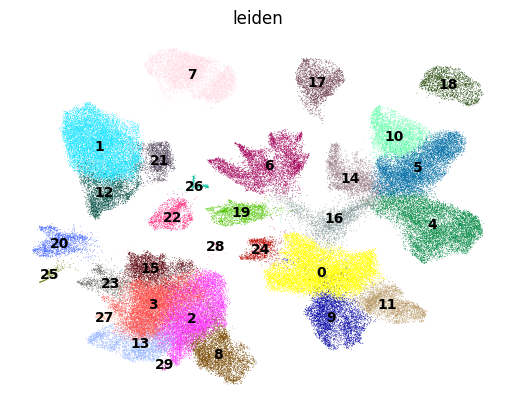

In [129]:
sc.pl.umap(adata, color = ['leiden'], frameon = False, legend_loc = "on data")

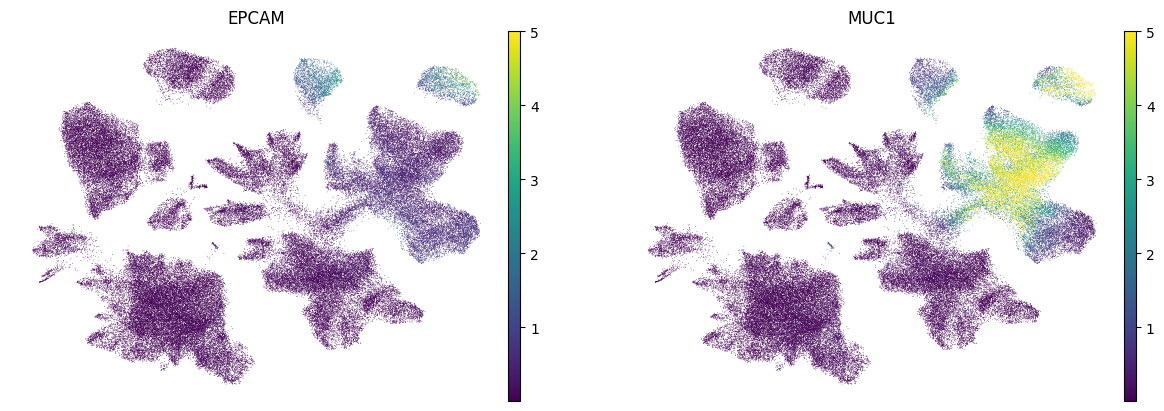

In [130]:
sc.pl.umap(adata, color = ['EPCAM', 'MUC1'], frameon = False, layer = 'scvi_normalized', vmax = 5)